  - date
  - time 
  - route
  - traffic type (int/dom)
  - service type (schduled, charter, etc)
  - direction
  - holiday at destination
  - holiday at origin
  - weekday #

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
import xgboost as xgb


In [2]:
# read csv
data_origin = pd.read_csv(
    "/home/antoine/projects/forecasting/KIX_AODB_data.csv",
    low_memory=False,
)
# select only useful columns
data = data_origin[
    [
        "Service Type",  # string
        "Traffic Type",  # string
        "Capacity",  # to convert to int
        "L Board Pax",  # int already
        "Direction",  # string
        "Date",  # date to convert to int for year/month/date
        "time",  # time to convert to int for hour
        "Routing-FirstLeg",  # string, should be country
    ]
].copy()


In [3]:
# change capacity to numerical
data["Capacity"] = pd.to_numeric(data["Capacity"], errors="coerce")

# split date into year month day
data["Year"] = pd.to_datetime(data["Date"]).apply(lambda x: x.year)
data["Month"] = pd.to_datetime(data["Date"]).apply(lambda x: x.month)
data["Day"] = pd.to_datetime(data["Date"]).apply(lambda x: x.day)
data.drop("Date", axis="columns", inplace=True)

# change time to number of hour (int)
data["Hour"] = pd.to_datetime(data["time"]).apply(lambda x: x.hour)
data.drop("time", axis="columns", inplace=True)


In [4]:
# drop na and convert to int
data.dropna(inplace=True)
data["Capacity"] = data["Capacity"].astype("int")
data["L Board Pax"] = data["L Board Pax"].astype("int")


# filter out rows with irrelevant values
mask = (
    (data["Service Type"].isin(["C", "G", "J"]))
    & (data["Capacity"] != 0)
    & (data["L Board Pax"] != 0)
)
data = data[mask].copy()

# replace capacity and pax with Load Factor
data["Load Factor"] = data["L Board Pax"] / data["Capacity"]
data.drop(["L Board Pax", "Capacity"], axis="columns", inplace=True)

# change routing to Country name
data_airports = pd.read_csv(
    "/home/antoine/projects/forecasting/AODB_airport_master.csv"
)
repl = data_airports[["ICAO", "Country"]].set_index("ICAO").T.to_dict(orient="records")
data["Country"] = data["Routing-FirstLeg"].map(*repl)
data.drop("Routing-FirstLeg", axis="columns", inplace=True)


In [5]:
# change types for categories
data["Service Type"] = data["Service Type"].astype("category")
data["Traffic Type"] = data["Traffic Type"].astype("category")
data["Direction"] = data["Direction"].astype("category")
data["Country"] = data["Country"].astype("category")


In [6]:
X = data.drop("Load Factor", axis=1)
y = data["Load Factor"]


In [8]:
# one hot encoding of categories
transformer = make_column_transformer(
    (OneHotEncoder(sparse=False), ["Service Type", "Traffic Type", "Direction", "Country"]),
    remainder="passthrough",
)
X_onehot = transformer.fit_transform(X)
X_onehot_df = pd.DataFrame(X_onehot, columns=transformer.get_feature_names_out())
X_onehot_df.head()

,onehotencoder__Service Type_C,onehotencoder__Service Type_G,onehotencoder__Service Type_J,onehotencoder__Traffic Type_DOMESTIC,onehotencoder__Traffic Type_INTERNATIONAL,onehotencoder__Direction_Arrival,onehotencoder__Direction_Departure,onehotencoder__Country_Australia,onehotencoder__Country_China,onehotencoder__Country_France,...,onehotencoder__Country_Singapore,"onehotencoder__Country_Taiwan, Province of China",onehotencoder__Country_Thailand,onehotencoder__Country_United Arab Emirates,onehotencoder__Country_United States,onehotencoder__Country_Viet Nam,remainder__Year,remainder__Month,remainder__Day,remainder__Hour
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,8.0,4.0,11.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,8.0,6.0,11.0
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,8.0,8.0,11.0
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,8.0,9.0,11.0
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,8.0,10.0,11.0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_onehot_df, y, random_state=1)


In [10]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

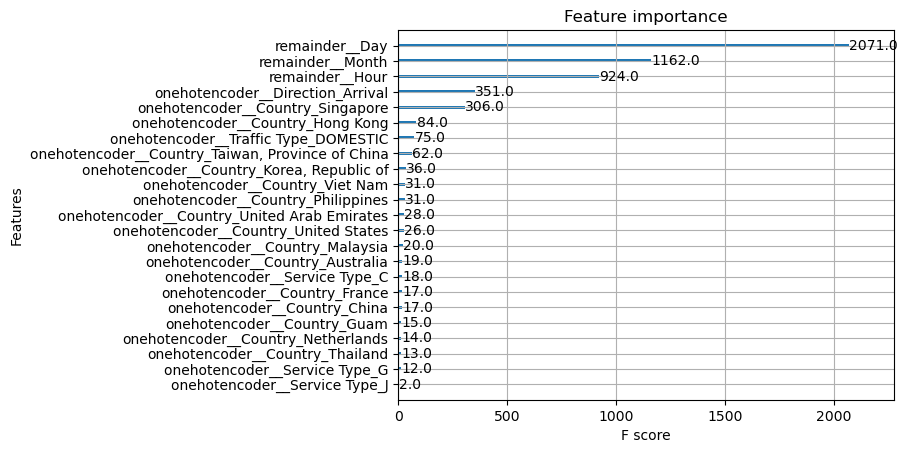

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

xgb.plot_importance(model, ax=plt.gca())

In [12]:
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

In [13]:
from sklearn.metrics import mean_squared_error, r2_score 

In [14]:
print( r2_score(y_train, pred_train) ) # how much variance the model explains?

0.9908859938427538


In [15]:
print( mean_squared_error(y_train, pred_train) )  ##  lower -> better ?? 

0.0487855413874176


In [16]:
model.score(X_test, y_test)  ## R^2

0.3307010267252548

In [17]:
print(r2_score(y_test, pred_test))

0.3307010267252548
